# Гайд по scikit-learn

**scikit-learn** — главная библиотека машинного обучения в Python. Она предоставляет готовые реализации десятков алгоритмов, утилиты для подготовки данных и инструменты оценки моделей.

В этом ноутбуке мы пройдём весь типичный ML-пайплайн:
1. Установка
2. Загрузка датасета
3. Исследование данных
4. Разделение на train/test
5. Масштабирование признаков
6. Обучение нескольких моделей
7. Предсказание меток и вероятностей
8. Отчёт о качестве (classification_report)
9. Сравнение моделей

---
## 1. Установка

scikit-learn устанавливается через `pip`. Флаг `-q` подавляет лишний вывод при установке.

> Если вы работаете в Google Colab — scikit-learn уже установлен, эту ячейку можно пропустить.

In [1]:
# Устанавливаем scikit-learn и дополнительные зависимости
%pip install -q scikit-learn numpy pandas matplotlib seaborn jinja2

Note: you may need to restart the kernel to use updated packages.


---
## 2. Импорт библиотек

Соберём все нужные инструменты в одном месте. Хорошая практика — делать все импорты в начале ноутбука, чтобы сразу было видно, что используется.

In [2]:
# Стандартные библиотеки
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# Датасет
from sklearn.datasets import load_breast_cancer

# Подготовка данных
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler

# Модели
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.svm import SVC
from sklearn.neighbors import KNeighborsClassifier

# Метрики
from sklearn.metrics import (
    classification_report,
    accuracy_score,
    confusion_matrix,
    ConfusionMatrixDisplay
)

print("Все библиотеки успешно импортированы!")

Все библиотеки успешно импортированы!


---
## 3. Загрузка датасета

Мы будем работать с датасетом **Breast Cancer Wisconsin** — классическим набором данных для бинарной классификации.

**Задача:** по 30 медицинским характеристикам опухоли определить, является ли она злокачественной (`malignant = 0`) или доброкачественной (`benign = 1`).

scikit-learn содержит несколько встроенных датасетов — они идеально подходят для обучения, потому что уже очищены и готовы к работе.

In [3]:
# Загружаем датасет
# as_frame=True — вернёт данные как pandas DataFrame, а не numpy массив
data = load_breast_cancer(as_frame=True)

# data — это объект типа Bunch (словарь с удобным доступом через точку)
# Посмотрим, что внутри
print("Ключи датасета:", data.keys())

Ключи датасета: dict_keys(['data', 'target', 'frame', 'target_names', 'DESCR', 'feature_names', 'filename', 'data_module'])


Объект `Bunch` содержит:
- `data` — матрица признаков (X)
- `target` — целевые метки (y)
- `feature_names` — названия признаков
- `target_names` — названия классов
- `DESCR` — полное описание датасета

In [4]:
# Читаем описание датасета (первые 1500 символов)
print(data.DESCR[:1500])

.. _breast_cancer_dataset:

Breast cancer Wisconsin (diagnostic) dataset
--------------------------------------------

**Data Set Characteristics:**

:Number of Instances: 569

:Number of Attributes: 30 numeric, predictive attributes and the class

:Attribute Information:
    - radius (mean of distances from center to points on the perimeter)
    - texture (standard deviation of gray-scale values)
    - perimeter
    - area
    - smoothness (local variation in radius lengths)
    - compactness (perimeter^2 / area - 1.0)
    - concavity (severity of concave portions of the contour)
    - concave points (number of concave portions of the contour)
    - symmetry
    - fractal dimension ("coastline approximation" - 1)

    The mean, standard error, and "worst" or largest (mean of the three
    worst/largest values) of these features were computed for each image,
    resulting in 30 features.  For instance, field 0 is Mean Radius, field
    10 is Radius SE, field 20 is Worst Radius.

    - 

---
## 4. Исследование данных (EDA)

Прежде чем обучать модель, всегда нужно **изучить данные**. Это помогает понять структуру, найти проблемы и выбрать подходящий алгоритм.

Извлекаем признаки и целевую переменную

In [5]:
X = data.data      # DataFrame с признаками
y = data.target    # Series с метками (0 = злокачественная, 1 = доброкачественная)

print(f"Размер матрицы признаков X: {X.shape}")
print(f"  - строк (объектов): {X.shape[0]}")
print(f"  - столбцов (признаков): {X.shape[1]}")
print(f"\nРазмер вектора меток y: {y.shape}")
print(f"\nКлассы: {data.target_names}")

Размер матрицы признаков X: (569, 30)
  - строк (объектов): 569
  - столбцов (признаков): 30

Размер вектора меток y: (569,)

Классы: ['malignant' 'benign']


Смотрим на первые 5 строк датасета
Каждая строка — один пациент, каждый столбец — одна характеристика опухоли

In [6]:
X.head()

,mean radius,mean texture,mean perimeter,mean area,mean smoothness,mean compactness,mean concavity,mean concave points,mean symmetry,mean fractal dimension,...,worst radius,worst texture,worst perimeter,worst area,worst smoothness,worst compactness,worst concavity,worst concave points,worst symmetry,worst fractal dimension
0,17.99,10.38,122.80,1001.0,0.11840,0.27760,0.3001,0.14710,0.2419,0.07871,...,25.38,17.33,184.60,2019.0,0.1622,0.6656,0.7119,0.2654,0.4601,0.11890
1,20.57,17.77,132.90,1326.0,0.08474,0.07864,0.0869,0.07017,0.1812,0.05667,...,24.99,23.41,158.80,1956.0,0.1238,0.1866,0.2416,0.1860,0.2750,0.08902
2,19.69,21.25,130.00,1203.0,0.10960,0.15990,0.1974,0.12790,0.2069,0.05999,...,23.57,25.53,152.50,1709.0,0.1444,0.4245,0.4504,0.2430,0.3613,0.08758
3,11.42,20.38,77.58,386.1,0.14250,0.28390,0.2414,0.10520,0.2597,0.09744,...,14.91,26.50,98.87,567.7,0.2098,0.8663,0.6869,0.2575,0.6638,0.17300
4,20.29,14.34,135.10,1297.0,0.10030,0.13280,0.1980,0.10430,0.1809,0.05883,...,22.54,16.67,152.20,1575.0,0.1374,0.2050,0.4000,0.1625,0.2364,0.07678


Статистика по признакам: среднее, стандартное отклонение, минимум, максимум

In [7]:
# Обратите внимание: признаки имеют ОЧЕНЬ разные масштабы — это важно для некоторых алгоритмов!
X.describe().round(2)

,mean radius,mean texture,mean perimeter,mean area,mean smoothness,mean compactness,mean concavity,mean concave points,mean symmetry,mean fractal dimension,...,worst radius,worst texture,worst perimeter,worst area,worst smoothness,worst compactness,worst concavity,worst concave points,worst symmetry,worst fractal dimension
count,569.00,569.00,569.00,569.00,569.00,569.00,569.00,569.00,569.00,569.00,...,569.00,569.00,569.00,569.00,569.00,569.00,569.00,569.00,569.00,569.00
mean,14.13,19.29,91.97,654.89,0.10,0.10,0.09,0.05,0.18,0.06,...,16.27,25.68,107.26,880.58,0.13,0.25,0.27,0.11,0.29,0.08
std,3.52,4.30,24.30,351.91,0.01,0.05,0.08,0.04,0.03,0.01,...,4.83,6.15,33.60,569.36,0.02,0.16,0.21,0.07,0.06,0.02
min,6.98,9.71,43.79,143.50,0.05,0.02,0.00,0.00,0.11,0.05,...,7.93,12.02,50.41,185.20,0.07,0.03,0.00,0.00,0.16,0.06
25%,11.70,16.17,75.17,420.30,0.09,0.06,0.03,0.02,0.16,0.06,...,13.01,21.08,84.11,515.30,0.12,0.15,0.11,0.06,0.25,0.07
50%,13.37,18.84,86.24,551.10,0.10,0.09,0.06,0.03,0.18,0.06,...,14.97,25.41,97.66,686.50,0.13,0.21,0.23,0.10,0.28,0.08
75%,15.78,21.80,104.10,782.70,0.11,0.13,0.13,0.07,0.20,0.07,...,18.79,29.72,125.40,1084.00,0.15,0.34,0.38,0.16,0.32,0.09
max,28.11,39.28,188.50,2501.00,0.16,0.35,0.43,0.20,0.30,0.10,...,36.04,49.54,251.20,4254.00,0.22,1.06,1.25,0.29,0.66,0.21


Проверяем баланс классов

Дисбаланс классов — частая проблема в ML. Если один класс встречается намного реже, модель может просто игнорировать его.

Количество объектов каждого класса:
  Злокачественные (0): 212
  Доброкачественные (1): 357

Соотношение: 1.68 (1 к 1 — идеальный баланс)


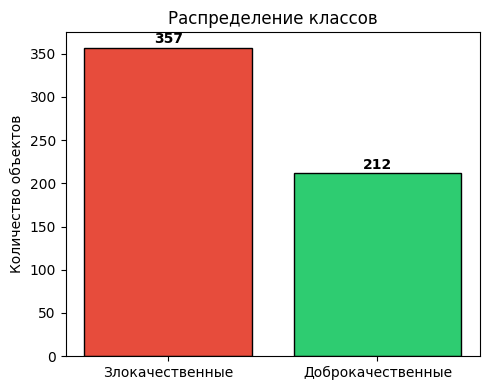

In [8]:
class_counts = y.value_counts()
print("Количество объектов каждого класса:")
print(f"  Злокачественные (0): {class_counts[0]}")
print(f"  Доброкачественные (1): {class_counts[1]}")
print(f"\nСоотношение: {class_counts[1] / class_counts[0]:.2f} (1 к 1 — идеальный баланс)")

# Визуализируем баланс
fig, ax = plt.subplots(figsize=(5, 4))
ax.bar(['Злокачественные', 'Доброкачественные'], class_counts.values,
       color=['#e74c3c', '#2ecc71'], edgecolor='black')
ax.set_title('Распределение классов')
ax.set_ylabel('Количество объектов')
for i, v in enumerate(class_counts.values):
    ax.text(i, v + 5, str(v), ha='center', fontweight='bold')
plt.tight_layout()
plt.show()

Проверяем наличие пропущенных значений

Многие алгоритмы не умеют работать с NaN — их нужно обрабатывать заранее

In [9]:
missing = X.isnull().sum().sum()
print(f"Пропущенных значений: {missing}")

Пропущенных значений: 0


Отлично! Датасет чистый, пропусков нет.

---
## 5. Разделение данных на обучающую и тестовую выборки

**Ключевой принцип ML:** модель оценивается на данных, которых она **не видела во время обучения**.

Поэтому мы делим данные:
- **Train (80%)** — на этих данных модель учится
- **Test (20%)** — на этих данных мы оцениваем качество

`random_state=42` фиксирует случайное разбиение, чтобы результаты были воспроизводимы.

In [10]:
# train_test_split разбивает данные случайно, но пропорционально
# stratify=y гарантирует, что в обоих сплитах будет одинаковое соотношение классов
X_train, X_test, y_train, y_test = train_test_split(
    X,                  # признаки
    y,                  # метки
    test_size=0.2,      # 20% отдаём на тест
    random_state=42,    # зерно случайности для воспроизводимости
    stratify=y          # сохраняем баланс классов в обоих сплитах
)

print(f"Размер обучающей выборки: {X_train.shape}")
print(f"Размер тестовой выборки:  {X_test.shape}")
print(f"\nБаланс классов в train:")
print(y_train.value_counts().to_dict())
print(f"\nБаланс классов в test:")
print(y_test.value_counts().to_dict())

Размер обучающей выборки: (455, 30)
Размер тестовой выборки:  (114, 30)

Баланс классов в train:
{1: 285, 0: 170}

Баланс классов в test:
{1: 72, 0: 42}


---
## 6. Масштабирование признаков

Помните, что признаки имели разные масштабы (от 0.001 до 2500)? Это проблема для алгоритмов, основанных на расстояниях (KNN, SVM) и градиентном спуске (Logistic Regression).

**`StandardScaler`** приводит каждый признак к стандартному нормальному распределению (среднее = 0, стандартное отклонение = 1):

$$z = \frac{x - \mu}{\sigma}$$

> **Важно:** `fit` вызываем **только на train**, чтобы не допустить "утечки данных" (data leakage) из теста.

In [11]:
# Создаём объект масштабировщика
scaler = StandardScaler()

# fit() — вычисляет среднее и стандартное отклонение ПО ТРЕНИРОВОЧНЫМ данным
# transform() — применяет нормализацию
# fit_transform() — делает оба шага сразу (только для train!)
X_train_scaled = scaler.fit_transform(X_train)

# Для теста — только transform() с уже вычисленными параметрами от train
# Мы не должны "подглядывать" в тестовые данные
X_test_scaled = scaler.transform(X_test)

# Проверим результат на первом признаке
print("Первый признак ДО масштабирования:")
print(f"  mean={X_train.iloc[:, 0].mean():.4f}, std={X_train.iloc[:, 0].std():.4f}")
print("\nПервый признак ПОСЛЕ масштабирования:")
print(f"  mean={X_train_scaled[:, 0].mean():.4f}, std={X_train_scaled[:, 0].std():.4f}")

Первый признак ДО масштабирования:
  mean=14.0672, std=3.4994

Первый признак ПОСЛЕ масштабирования:
  mean=-0.0000, std=1.0000


---
## 7. Обучение моделей

Все модели в scikit-learn следуют одному API:
1. Создаём объект модели: `model = SomeModel(params)`
2. Обучаем: `model.fit(X_train, y_train)`
3. Предсказываем: `model.predict(X_test)`

Это позволяет легко сравнивать разные алгоритмы.

---
### Модель 1: Логистическая регрессия

Несмотря на название, **логистическая регрессия** — это классификатор. Она строит линейную границу между классами и оценивает вероятность принадлежности к классу через сигмоид-функцию. Быстрая, интерпретируемая, хороший baseline.

In [12]:
# max_iter — максимальное число итераций оптимизатора
# Увеличиваем до 1000, чтобы алгоритм точно сошёлся
lr_model = LogisticRegression(max_iter=1000, random_state=42)

# fit() — ключевой метод обучения. Модель "смотрит" на X_train_scaled и y_train
# и подбирает оптимальные веса
lr_model.fit(X_train_scaled, y_train)

print("Логистическая регрессия обучена!")
print(f"Количество коэффициентов (по одному на признак): {len(lr_model.coef_[0])}")

Логистическая регрессия обучена!
Количество коэффициентов (по одному на признак): 30


---
### Модель 2: Дерево решений (Decision Tree)

**Decision Tree** — алгоритм, который строит дерево вопросов: на каждом узле выбирается признак и порог, разделяющий данные наилучшим образом. Процесс повторяется рекурсивно, пока не достигается листовой узел с ответом.

Ключевые параметры:
- `max_depth` — максимальная глубина дерева. Без ограничения дерево вырастет до полного запоминания тренировочных данных (переобучение). Ограничение глубины — основной способ регуляризации.
- `criterion` — критерий разбиения: `'gini'` (по умолчанию) или `'entropy'`.

Главное преимущество дерева перед ансамблями — **интерпретируемость**: его можно нарисовать и объяснить, почему принято то или иное решение.

In [13]:
# max_depth=5 — ограничиваем глубину дерева, чтобы избежать переобучения
# Без этого параметра дерево запомнит весь train и будет плохо работать на новых данных
# criterion='gini' — мера неоднородности узла (индекс Джини)
dt_model = DecisionTreeClassifier(max_depth=5, criterion='gini', random_state=42)

# Дерево решений не требует масштабирования — оно работает с пороговыми значениями признаков,
# а не с расстояниями. Но передаём scaled-данные для единообразия с другими моделями.
dt_model.fit(X_train_scaled, y_train)

print(f"Дерево решений обучено!")
print(f"Максимальная глубина: {dt_model.max_depth}")
print(f"Фактическая глубина построенного дерева: {dt_model.get_depth()}")
print(f"Количество листьев: {dt_model.get_n_leaves()}")

Дерево решений обучено!
Максимальная глубина: 5
Фактическая глубина построенного дерева: 5
Количество листьев: 15


---
### Модель 3: Метод опорных векторов (SVM)

**SVM** ищет гиперплоскость, которая максимально разделяет классы. Очень эффективен при большом числе признаков. Параметр `probability=True` нужен, чтобы модель умела возвращать вероятности (по умолчанию SVM этого не делает).

In [14]:
# probability=True — включаем возможность получать вероятности через predict_proba()
# Без этого флага SVM вернёт только метки классов
# kernel='rbf' — радиально-базисная функция (стандартный выбор)
svm_model = SVC(probability=True, kernel='rbf', random_state=42)

svm_model.fit(X_train_scaled, y_train)

print(f"SVM обучен! Kernel: {svm_model.kernel}")
print(f"Количество опорных векторов: {svm_model.support_vectors_.shape[0]}")

SVM обучен! Kernel: rbf
Количество опорных векторов: 97


---
### Модель 4: Метод K ближайших соседей (KNN)

**KNN** — простой алгоритм: чтобы классифицировать новый объект, он находит K ближайших объектов в тренировочных данных и назначает наиболее частый среди них класс. Не требует обучения как такового, но медленно работает на предсказании.

In [15]:
# n_neighbors — количество ближайших соседей для голосования
# Маленькое значение -> переобучение, большое -> недообучение
# 5 — хороший стартовый выбор
knn_model = KNeighborsClassifier(n_neighbors=5)

# KNN "запоминает" весь тренировочный датасет
# Масштабирование критически важно: без него признаки с большими значениями
# будут доминировать при вычислении расстояний
knn_model.fit(X_train_scaled, y_train)

print(f"KNN готов! Число соседей: {knn_model.n_neighbors}")

KNN готов! Число соседей: 5


---
## 8. Предсказание меток классов

Метод `predict()` возвращает **метку класса** (0 или 1) для каждого объекта тестовой выборки.

Это ответ на вопрос: _"К какому классу относится этот объект?"_

In [16]:
# Получаем предсказания меток для каждой модели
y_pred_lr  = lr_model.predict(X_test_scaled)
y_pred_dt  = dt_model.predict(X_test_scaled)
y_pred_svm = svm_model.predict(X_test_scaled)
y_pred_knn = knn_model.predict(X_test_scaled)

# Посмотрим на первые 10 предсказаний и истинные метки
print("Истинные метки (первые 10):      ", list(y_test[:10]))
print("Логистическая регрессия:          ", list(y_pred_lr[:10]))
print("Дерево решений:                   ", list(y_pred_dt[:10]))
print("SVM:                              ", list(y_pred_svm[:10]))
print("KNN:                              ", list(y_pred_knn[:10]))

# Символы классов
class_names = data.target_names
print(f"\n0 = {class_names[0]}, 1 = {class_names[1]}")

Истинные метки (первые 10):       [0, 1, 0, 1, 0, 1, 1, 0, 0, 0]
Логистическая регрессия:           [np.int64(0), np.int64(1), np.int64(0), np.int64(1), np.int64(0), np.int64(1), np.int64(1), np.int64(0), np.int64(0), np.int64(0)]
Дерево решений:                    [np.int64(0), np.int64(1), np.int64(0), np.int64(1), np.int64(0), np.int64(1), np.int64(1), np.int64(0), np.int64(0), np.int64(0)]
SVM:                               [np.int64(0), np.int64(1), np.int64(0), np.int64(1), np.int64(0), np.int64(1), np.int64(1), np.int64(0), np.int64(0), np.int64(0)]
KNN:                               [np.int64(0), np.int64(1), np.int64(0), np.int64(0), np.int64(0), np.int64(1), np.int64(1), np.int64(0), np.int64(0), np.int64(0)]

0 = malignant, 1 = benign


In [17]:
# Быстрое сравнение точности (accuracy) всех моделей
models = {
    'Logistic Regression': y_pred_lr,
    'Decision Tree':       y_pred_dt,
    'SVM':                 y_pred_svm,
    'KNN':                 y_pred_knn,
}

print("Точность (Accuracy) на тестовой выборке:")
print("-" * 40)
for name, preds in models.items():
    acc = accuracy_score(y_test, preds)
    print(f"  {name:<25} {acc:.4f} ({acc*100:.2f}%)")

Точность (Accuracy) на тестовой выборке:
----------------------------------------
  Logistic Regression       0.9825 (98.25%)
  Decision Tree             0.9211 (92.11%)
  SVM                       0.9825 (98.25%)
  KNN                       0.9561 (95.61%)


---
## 9. Предсказание вероятностей

Метод `predict_proba()` возвращает **вероятность** принадлежности к каждому классу.

Это ответ на вопрос: _"Насколько модель уверена в своём ответе?"_

Вероятности полезны когда:
- Нужно настроить порог классификации (не всегда 0.5 оптимален)
- Важна "цена" ошибки (например, в медицине лучше перестраховаться)
- Строится ансамбль из нескольких моделей

In [18]:
# predict_proba() возвращает матрицу [n_samples x n_classes]
# Для бинарной классификации — два столбца: [P(класс=0), P(класс=1)]
# Сумма по строке всегда равна 1.0

proba_lr  = lr_model.predict_proba(X_test_scaled)
proba_dt  = dt_model.predict_proba(X_test_scaled)
proba_svm = svm_model.predict_proba(X_test_scaled)
proba_knn = knn_model.predict_proba(X_test_scaled)

print(f"Форма матрицы вероятностей: {proba_lr.shape}")
print(f"Строки = объекты ({proba_lr.shape[0]}), Столбцы = классы ({proba_lr.shape[1]})\n")

# Создаём красивую таблицу для первых 5 объектов
demo_df = pd.DataFrame({
    'Истинный класс':       list(y_test[:5].map({0: 'malignant', 1: 'benign'})),
    'LR P(malignant)':      proba_lr[:5, 0].round(3),
    'LR P(benign)':         proba_lr[:5, 1].round(3),
    'DT P(malignant)':      proba_dt[:5, 0].round(3),
    'DT P(benign)':         proba_dt[:5, 1].round(3),
    'SVM P(malignant)':     proba_svm[:5, 0].round(3),
    'SVM P(benign)':        proba_svm[:5, 1].round(3),
})
demo_df

Форма матрицы вероятностей: (114, 2)
Строки = объекты (114), Столбцы = классы (2)



,Истинный класс,LR P(malignant),LR P(benign),DT P(malignant),DT P(benign),SVM P(malignant),SVM P(benign)
0,malignant,1.000,0.000,1.000,0.000,0.999,0.001
1,benign,0.000,1.000,0.004,0.996,0.000,1.000
2,malignant,0.994,0.006,1.000,0.000,0.991,0.009
3,benign,0.466,0.534,0.000,1.000,0.436,0.564
4,malignant,1.000,0.000,1.000,0.000,0.994,0.006


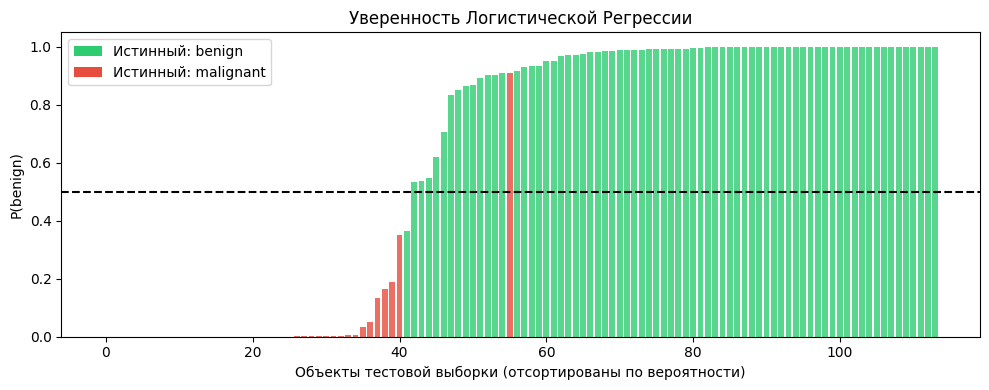

Красные бары справа от порога — это ошибки классификации (FP)
Зелёные бары слева от порога — тоже ошибки (FN)


In [19]:
# Визуализируем уверенность модели (LogReg) на тестовых данных
# Вероятность принадлежности к классу "benign" (1)

fig, ax = plt.subplots(figsize=(10, 4))

# Сортируем по вероятности для наглядности
proba_benign = proba_lr[:, 1]
sorted_idx = np.argsort(proba_benign)

colors = ['#e74c3c' if y == 0 else '#2ecc71' for y in y_test.values[sorted_idx]]
ax.bar(range(len(proba_benign)), proba_benign[sorted_idx], color=colors, alpha=0.8)
ax.axhline(y=0.5, color='black', linestyle='--', linewidth=1.5, label='Порог 0.5')
ax.set_xlabel('Объекты тестовой выборки (отсортированы по вероятности)')
ax.set_ylabel('P(benign)')
ax.set_title('Уверенность Логистической Регрессии')

# Легенда
from matplotlib.patches import Patch
legend_elements = [Patch(facecolor='#2ecc71', label='Истинный: benign'),
                   Patch(facecolor='#e74c3c', label='Истинный: malignant')]
ax.legend(handles=legend_elements, loc='upper left')

plt.tight_layout()
plt.show()

print("Красные бары справа от порога — это ошибки классификации (FP)")
print("Зелёные бары слева от порога — тоже ошибки (FN)")

---
## 10. Отчёт о качестве классификации

**`classification_report`** — главный инструмент оценки классификатора. Он показывает несколько метрик сразу:

| Метрика | Формула | Что означает |
|---|---|---|
| **Precision** | TP / (TP + FP) | Из всех предсказанных «класс X», сколько верных? |
| **Recall** | TP / (TP + FN) | Из всех истинных «класс X», сколько нашли? |
| **F1-score** | 2 * P * R / (P + R) | Гармоническое среднее Precision и Recall |
| **Support** | — | Количество объектов этого класса в тесте |

В медицине часто важнее **recall** (не пропустить больного), чем precision.

Отчёт для Логистической Регрессии

In [20]:
print("=" * 55)
print("     LOGISTIC REGRESSION — Classification Report")
print("=" * 55)
print(classification_report(y_test, y_pred_lr, target_names=data.target_names))

     LOGISTIC REGRESSION — Classification Report
              precision    recall  f1-score   support

   malignant       0.98      0.98      0.98        42
      benign       0.99      0.99      0.99        72

    accuracy                           0.98       114
   macro avg       0.98      0.98      0.98       114
weighted avg       0.98      0.98      0.98       114



Отчёт для Дерева решений

In [21]:
print("=" * 55)
print("       DECISION TREE — Classification Report")
print("=" * 55)
print(classification_report(y_test, y_pred_dt, target_names=data.target_names))

       DECISION TREE — Classification Report
              precision    recall  f1-score   support

   malignant       0.87      0.93      0.90        42
      benign       0.96      0.92      0.94        72

    accuracy                           0.92       114
   macro avg       0.91      0.92      0.92       114
weighted avg       0.92      0.92      0.92       114



Отчёт для SVM

In [22]:
print("=" * 55)
print("              SVM — Classification Report")
print("=" * 55)
print(classification_report(y_test, y_pred_svm, target_names=data.target_names))

              SVM — Classification Report
              precision    recall  f1-score   support

   malignant       0.98      0.98      0.98        42
      benign       0.99      0.99      0.99        72

    accuracy                           0.98       114
   macro avg       0.98      0.98      0.98       114
weighted avg       0.98      0.98      0.98       114



Отчёт для KNN

In [23]:
print("=" * 55)
print("              KNN — Classification Report")
print("=" * 55)
print(classification_report(y_test, y_pred_knn, target_names=data.target_names))

              KNN — Classification Report
              precision    recall  f1-score   support

   malignant       0.95      0.93      0.94        42
      benign       0.96      0.97      0.97        72

    accuracy                           0.96       114
   macro avg       0.96      0.95      0.95       114
weighted avg       0.96      0.96      0.96       114



---
## 11. Матрица ошибок (Confusion Matrix)

**Confusion Matrix** показывает в деталях, как именно ошиблась модель:
- **TP** (True Positive) — верно предсказали положительный класс
- **TN** (True Negative) — верно предсказали отрицательный класс  
- **FP** (False Positive) — ошиблись: сказали "benign", а было "malignant"
- **FN** (False Negative) — ошиблись: сказали "malignant", а было "benign"

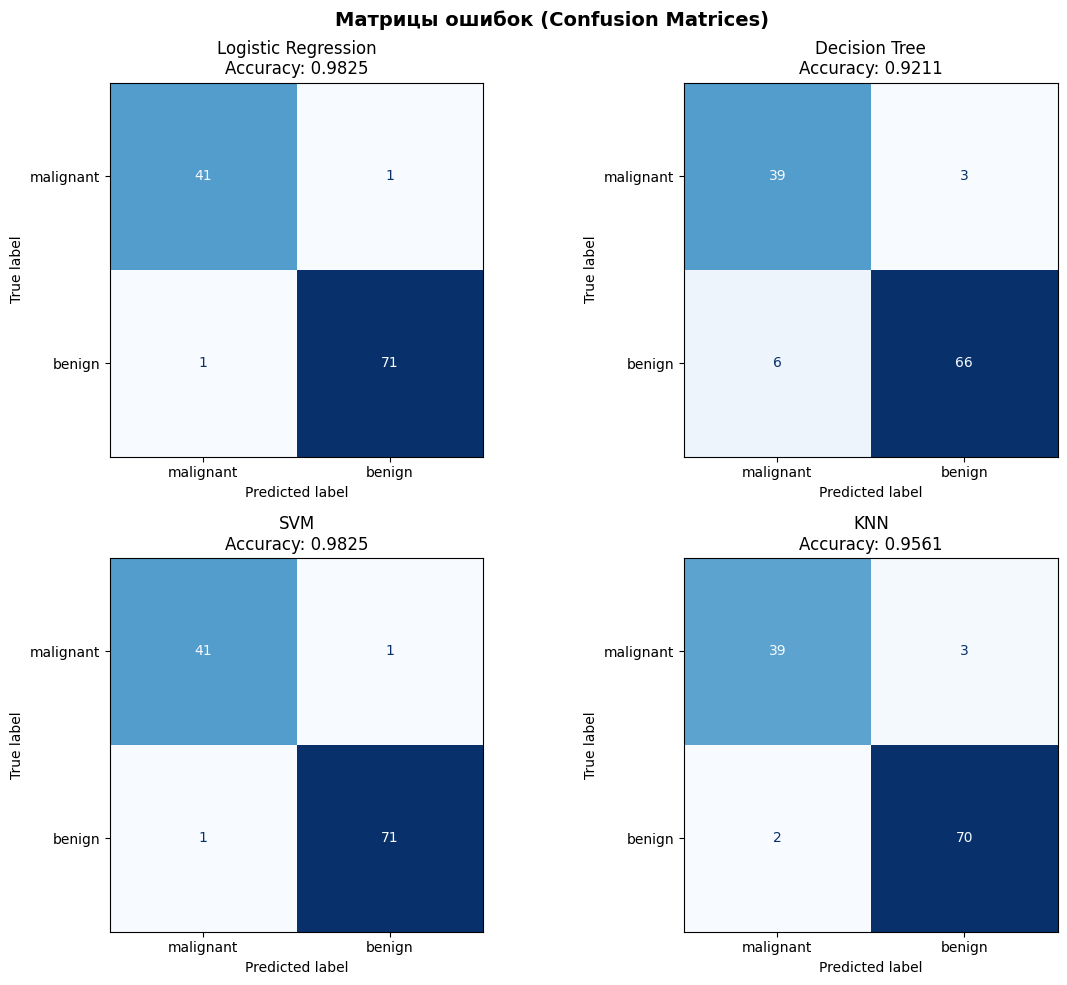

In [24]:
# Строим матрицы ошибок для всех четырёх моделей
fig, axes = plt.subplots(2, 2, figsize=(12, 10))
fig.suptitle('Матрицы ошибок (Confusion Matrices)', fontsize=14, fontweight='bold')

model_preds = [
    ('Logistic Regression', y_pred_lr),
    ('Decision Tree',       y_pred_dt),
    ('SVM',                 y_pred_svm),
    ('KNN',                 y_pred_knn),
]

for ax, (name, preds) in zip(axes.flatten(), model_preds):
    cm = confusion_matrix(y_test, preds)
    disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=data.target_names)
    disp.plot(ax=ax, colorbar=False, cmap='Blues')
    acc = accuracy_score(y_test, preds)
    ax.set_title(f'{name}\nAccuracy: {acc:.4f}')

plt.tight_layout()
plt.show()

---
## 12. Итоговое сравнение моделей

Собираем все метрики в одну таблицу для наглядного сравнения.

In [25]:
from sklearn.metrics import precision_score, recall_score, f1_score

results = []
for name, preds in model_preds:
    results.append({
        'Модель':     name,
        'Accuracy':   round(accuracy_score(y_test, preds), 4),
        'Precision':  round(precision_score(y_test, preds, average='weighted'), 4),
        'Recall':     round(recall_score(y_test, preds, average='weighted'), 4),
        'F1-score':   round(f1_score(y_test, preds, average='weighted'), 4),
    })

results_df = pd.DataFrame(results).set_index('Модель')

# Подсветим лучшие значения в каждой колонке
results_df.style.highlight_max(axis=0, color='#d4edda')

,Accuracy,Precision,Recall,F1-score
Модель,,,,
Logistic Regression,0.982500,0.982500,0.982500,0.982500
Decision Tree,0.921100,0.923400,0.921100,0.921600
SVM,0.982500,0.982500,0.982500,0.982500
KNN,0.956100,0.956100,0.956100,0.956000


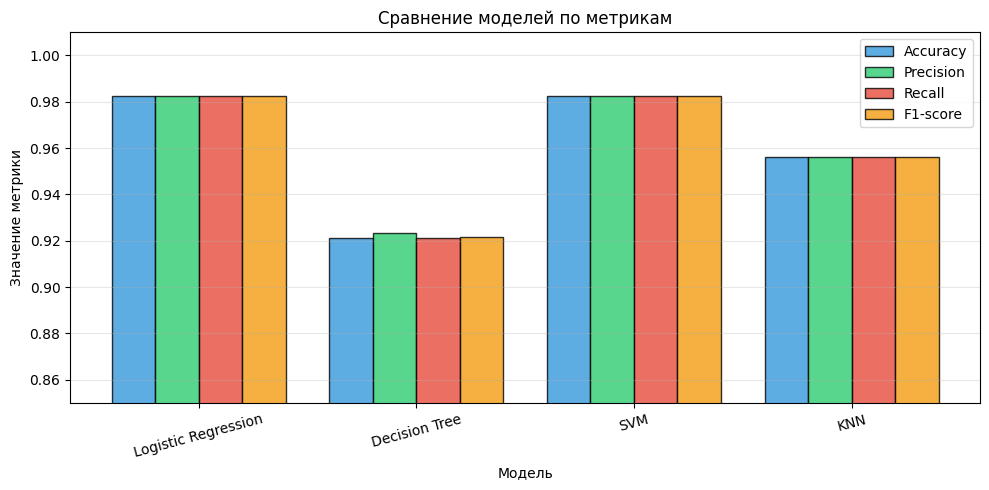

In [26]:
# Визуализация сравнения
fig, ax = plt.subplots(figsize=(10, 5))

x = np.arange(len(results_df))
width = 0.2
colors = ['#3498db', '#2ecc71', '#e74c3c', '#f39c12']

for i, metric in enumerate(['Accuracy', 'Precision', 'Recall', 'F1-score']):
    bars = ax.bar(x + i * width, results_df[metric], width, label=metric,
                  color=colors[i], alpha=0.8, edgecolor='black')

ax.set_xlabel('Модель')
ax.set_ylabel('Значение метрики')
ax.set_title('Сравнение моделей по метрикам')
ax.set_xticks(x + width * 1.5)
ax.set_xticklabels(results_df.index, rotation=15)
ax.set_ylim([0.85, 1.01])
ax.legend()
ax.grid(axis='y', alpha=0.3)

plt.tight_layout()
plt.show()

---
## 13. Pipeline — цепочка шагов в одном объекте

До этого мы делали масштабирование и обучение как два отдельных действия: сначала `scaler.fit_transform()`, потом `model.fit()`. В реальных проектах таких шагов может быть гораздо больше: очистка данных, генерация признаков, отбор признаков, масштабирование, и наконец — модель.

**`Pipeline`** позволяет соединить все шаги в один объект. Внутри он сам следит за тем, чтобы на train вызывался `fit_transform`, а на test — только `transform`. Никакой утечки данных невозможно по конструкции.

```
X_train ──► [StandardScaler] ──► [LogisticRegression] ──► y_pred
                  ↑ fit здесь          ↑ fit здесь
```

### Преимущества Pipeline

- **Защита от data leakage** — `fit` промежуточных шагов автоматически вызывается только на train-данных
- **Меньше кода** — не нужно вручную передавать данные между шагами
- **Один объект для сохранения** — `pickle` одного pipeline заменяет сохранение scaler + model по отдельности
- **Совместимость с GridSearchCV** — можно подбирать гиперпараметры любого шага, включая препроцессинг

### Недостатки Pipeline

- **Сложнее отлаживать** — если ошибка внутри шага, трейсбек глубже и менее читаемый
- **Не всегда удобен при EDA** — иногда нужно посмотреть на промежуточный результат (например, после масштабирования), что требует дополнительных телодвижений
- **Ограниченная гибкость** — если шаги зависят друг от друга нелинейно (например, результат одного шага меняет параметры другого), Pipeline не подходит

In [27]:
from sklearn.pipeline import Pipeline

# Pipeline принимает список кортежей: ('имя_шага', объект_шага)
# Имена шагов произвольные — они нужны для доступа к шагу по имени
# и для GridSearchCV (синтаксис: 'имя_шага__параметр')

# Pipeline для Логистической Регрессии
pipe_lr = Pipeline([
    ('scaler', StandardScaler()),           # шаг 1: масштабирование
    ('model',  LogisticRegression(max_iter=1000, random_state=42))  # шаг 2: классификатор
])

# Pipeline для Дерева решений
# Дерево не требует масштабирования, но мы добавляем scaler для единообразия
pipe_dt = Pipeline([
    ('scaler', StandardScaler()),
    ('model',  DecisionTreeClassifier(max_depth=5, criterion='gini', random_state=42))
])

# Pipeline для SVM
pipe_svm = Pipeline([
    ('scaler', StandardScaler()),
    ('model',  SVC(probability=True, kernel='rbf', random_state=42))
])

# Pipeline для KNN
pipe_knn = Pipeline([
    ('scaler', StandardScaler()),
    ('model',  KNeighborsClassifier(n_neighbors=5))
])

print("Все Pipeline созданы!")
print(f"\nСтруктура pipe_lr:")
print(pipe_lr)  # Pipeline показывает все свои шаги при печати

Все Pipeline созданы!

Структура pipe_lr:
Pipeline(steps=[('scaler', StandardScaler()),
                ('model', LogisticRegression(max_iter=1000, random_state=42))])


Теперь обучим все Pipeline. Обратите внимание: мы передаём **сырые данные** `X_train` и `X_test` — без предварительного масштабирования. Pipeline сам выполнит все шаги в правильном порядке.

In [28]:
pipelines = {
    'Logistic Regression': pipe_lr,
    'Decision Tree':       pipe_dt,
    'SVM':                 pipe_svm,
    'KNN':                 pipe_knn,
}

# fit() на Pipeline: внутри вызовет fit_transform для scaler, затем fit для model
# Передаём X_train — сырые, немасштабированные данные
for name, pipe in pipelines.items():
    pipe.fit(X_train, y_train)  # <-- не X_train_scaled, а X_train!
    print(f"  {name}: обучен")

  Logistic Regression: обучен
  Decision Tree: обучен
  SVM: обучен
  KNN: обучен


Сделаем сравнение ручного подхода и через использование Pipeline.

In [29]:
# predict() на Pipeline: внутри вызовет transform для scaler, затем predict для model
# Передаём X_test — тоже сырые данные, Pipeline сам масштабирует
print("Сравнение: ручной подход vs Pipeline\n")
print(f"{'Модель':<25} {'Ручной':<10} {'Pipeline':<10} {'Совпадает?'}")
print("-" * 55)

manual_preds  = [y_pred_lr,  y_pred_dt,  y_pred_svm,  y_pred_knn]
pipe_list     = [pipe_lr,    pipe_dt,    pipe_svm,    pipe_knn]

for (name, _), manual, pipe in zip(pipelines.items(), manual_preds, pipe_list):
    # predict() на Pipeline принимает сырые данные
    pipe_pred = pipe.predict(X_test)  # <-- не X_test_scaled!

    manual_acc = accuracy_score(y_test, manual)
    pipe_acc   = accuracy_score(y_test, pipe_pred)

    # Результаты должны совпадать: Pipeline делает то же самое, что и ручной подход
    match = "✓ Да" if np.array_equal(manual, pipe_pred) else "✗ Нет"
    print(f"  {name:<23} {manual_acc:.4f}    {pipe_acc:.4f}    {match}")

Сравнение: ручной подход vs Pipeline

Модель                    Ручной     Pipeline   Совпадает?
-------------------------------------------------------
  Logistic Regression     0.9825    0.9825    ✓ Да
  Decision Tree           0.9211    0.9211    ✓ Да
  SVM                     0.9825    0.9825    ✓ Да
  KNN                     0.9561    0.9561    ✓ Да


Предсказания совпадают — Pipeline даёт те же результаты, что и ручной подход, но кода значительно меньше.

---
### Бонус: Pipeline + GridSearchCV

Главная суперсила Pipeline раскрывается в связке с `GridSearchCV`. Можно перебирать гиперпараметры **любого шага** — и предобработки, и модели — в одном поиске. Параметры шага задаются через двойное подчёркивание: `'имя_шага__параметр'`.

In [30]:
from sklearn.model_selection import GridSearchCV

# Строим Pipeline, который будем оптимизировать
pipe_search = Pipeline([
    ('scaler', StandardScaler()),
    ('model',  LogisticRegression(random_state=42))
])

# Сетка гиперпараметров для перебора
# Синтаксис: 'имя_шага__параметр_модели'
# Здесь мы перебираем параметры шага 'model' (LogisticRegression)
param_grid = {
    'model__C':        [0.01, 0.1, 1, 10, 100],  # сила регуляризации (меньше C = сильнее)
    'model__solver':   ['lbfgs', 'liblinear'],     # алгоритм оптимизации
    'model__max_iter': [500, 1000],                # число итераций
}

# cv=5 — 5-кратная кросс-валидация: каждая комбинация параметров
# оценивается на 5 разных разбиениях train-данных
# scoring='f1_weighted' — оптимизируем F1, а не accuracy
grid_search = GridSearchCV(
    pipe_search,
    param_grid,
    cv=5,
    scoring='f1_weighted',
    n_jobs=-1,     # n_jobs=-1 — использовать все ядра процессора
    verbose=0
)

# fit() запускает перебор: Pipeline * количество комбинаций * cv фолдов
grid_search.fit(X_train, y_train)  # передаём сырые данные — Pipeline сам масштабирует

print(f"Лучшие гиперпараметры: {grid_search.best_params_}")
print(f"Лучший F1 на кросс-валидации: {grid_search.best_score_:.4f}")

# best_estimator_ — это уже обученный Pipeline с лучшими параметрами
best_pipe = grid_search.best_estimator_
y_pred_best = best_pipe.predict(X_test)

print(f"\nAccuracy лучшей модели на тесте: {accuracy_score(y_test, y_pred_best):.4f}")
print(f"\n{classification_report(y_test, y_pred_best, target_names=data.target_names)}")

Лучшие гиперпараметры: {'model__C': 0.1, 'model__max_iter': 500, 'model__solver': 'liblinear'}
Лучший F1 на кросс-валидации: 0.9802

Accuracy лучшей модели на тесте: 0.9825

              precision    recall  f1-score   support

   malignant       0.98      0.98      0.98        42
      benign       0.99      0.99      0.99        72

    accuracy                           0.98       114
   macro avg       0.98      0.98      0.98       114
weighted avg       0.98      0.98      0.98       114



---
## Итоги

В этом ноутбуке мы прошли полный цикл работы с scikit-learn — от загрузки данных до автоматизации пайплайна.

### Что мы сделали

| # | Этап | Инструмент | Зачем |
|---|------|------------|-------|
| 1 | Загрузка данных | `load_breast_cancer()` | Готовый датасет для классификации без лишней подготовки |
| 2 | Исследование (EDA) | `DataFrame.describe()`, `value_counts()` | Понять структуру, масштабы признаков, баланс классов |
| 3 | Разделение | `train_test_split(..., stratify=y)` | Честная оценка — модель не видит тест во время обучения |
| 4 | Масштабирование | `StandardScaler` | Привести признаки к одному масштабу для KNN, SVM, LogReg |
| 5 | Обучение моделей | `.fit(X_train, y_train)` | Единый API для всех алгоритмов scikit-learn |
| 6 | Предсказание меток | `.predict(X_test)` | Получить итоговый класс для каждого объекта |
| 7 | Предсказание вероятностей | `.predict_proba(X_test)` | Узнать уверенность модели и настроить порог решения |
| 8 | Оценка качества | `classification_report()` | Precision, Recall, F1 по каждому классу |
| 9 | Pipeline | `Pipeline([('scaler', ...), ('model', ...)])` | Объединить шаги, устранить возможность data leakage |
| 10 | Подбор гиперпараметров | `GridSearchCV(pipeline, param_grid, cv=5)` | Автоматически найти лучшую комбинацию параметров |

### Четыре модели, которые мы сравнили

| Модель | Когда использовать |
|--------|-------------------|
| **Logistic Regression** | Baseline, нужна интерпретируемость коэффициентов, данные линейно разделимы |
| **Decision Tree** | Нужно объяснить решение бизнесу, важна наглядность правил |
| **SVM** | Много признаков, данные нелинейно разделимы, небольшой датасет |
| **KNN** | Быстрый старт, нет предположений о распределении данных |

### Ключевые правила, которые нельзя нарушать

- `scaler.fit()` — **только на train**, иначе data leakage и завышенные метрики
- Оценивать модель — **только на test**, который не участвовал в обучении
- **Pipeline решает оба правила** выше автоматически — используйте его в реальных проектах